In [ ]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf    # extra added line
import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax, MaxPool1D
from keras.layers import GlobalAveragePooling1D     # extra added line
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D    # extra added line 
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
#imports to apply k-fold validation
from sklearn.model_selection import KFold, cross_val_score

import seaborn as sns
from typing import Tuple
import copy as cp
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [ ]:
path = '/content/drive/MyDrive/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read files
import natsort as ns
filenames = next(os.walk(path))[2]
# Split and save .csv , .txt 
records = list()
annotations = list()
# x = filenames.sort()
x = ns.natsorted(filenames)
print(x)

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [ ]:
print(len(records))
print(len(annotations))
print(records)
print(annotations)

48
48
['/content/drive/MyDrive/mitbih_database/101.csv', '/content/drive/MyDrive/mitbih_database/100.csv', '/content/drive/MyDrive/mitbih_database/102.csv', '/content/drive/MyDrive/mitbih_database/104.csv', '/content/drive/MyDrive/mitbih_database/103.csv', '/content/drive/MyDrive/mitbih_database/107.csv', '/content/drive/MyDrive/mitbih_database/106.csv', '/content/drive/MyDrive/mitbih_database/105.csv', '/content/drive/MyDrive/mitbih_database/108.csv', '/content/drive/MyDrive/mitbih_database/109.csv', '/content/drive/MyDrive/mitbih_database/111.csv', '/content/drive/MyDrive/mitbih_database/112.csv', '/content/drive/MyDrive/mitbih_database/113.csv', '/content/drive/MyDrive/mitbih_database/114.csv', '/content/drive/MyDrive/mitbih_database/115.csv', '/content/drive/MyDrive/mitbih_database/116.csv', '/content/drive/MyDrive/mitbih_database/118.csv', '/content/drive/MyDrive/mitbih_database/117.csv', '/content/drive/MyDrive/mitbih_database/121.csv', '/content/drive/MyDrive/mitbih_database/122

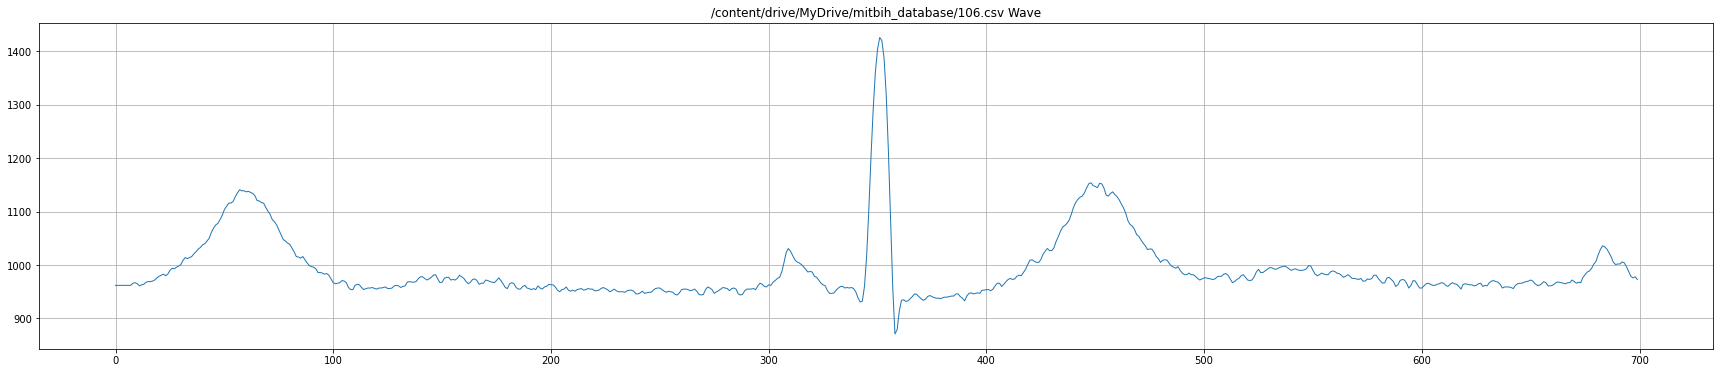

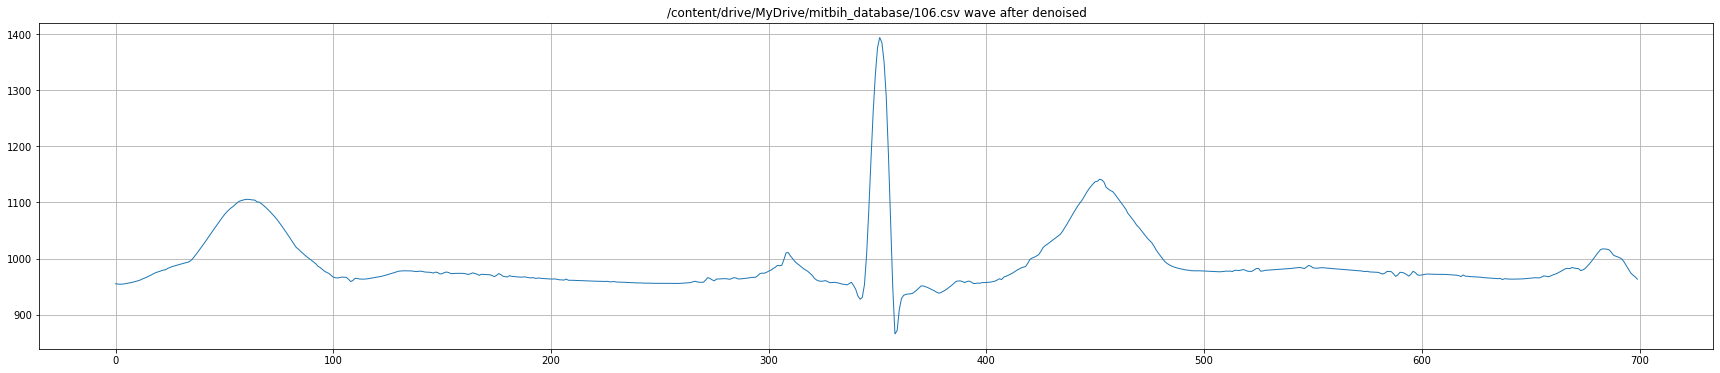

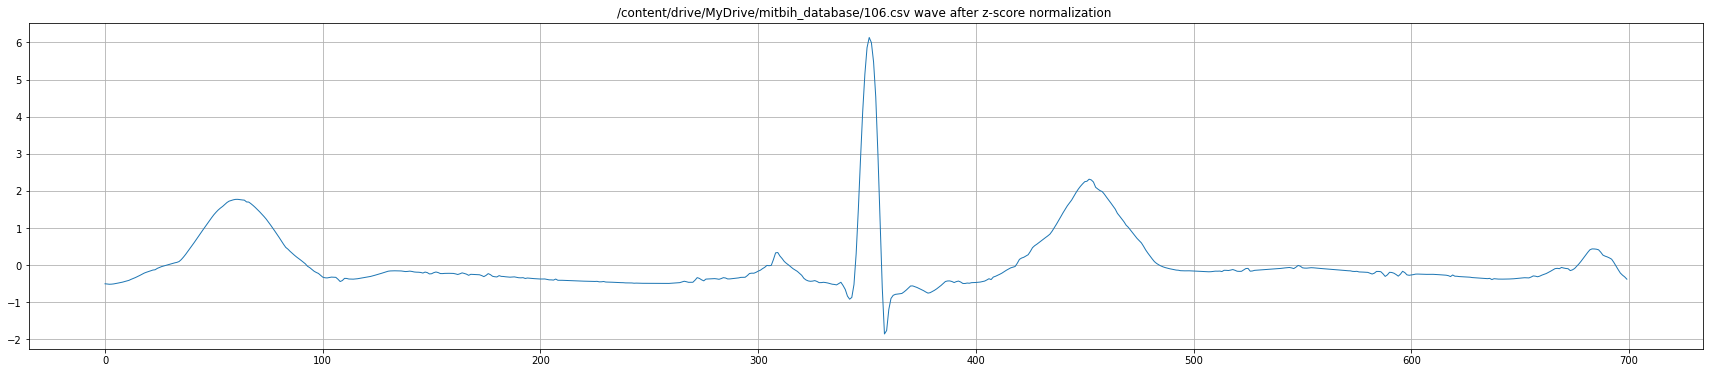

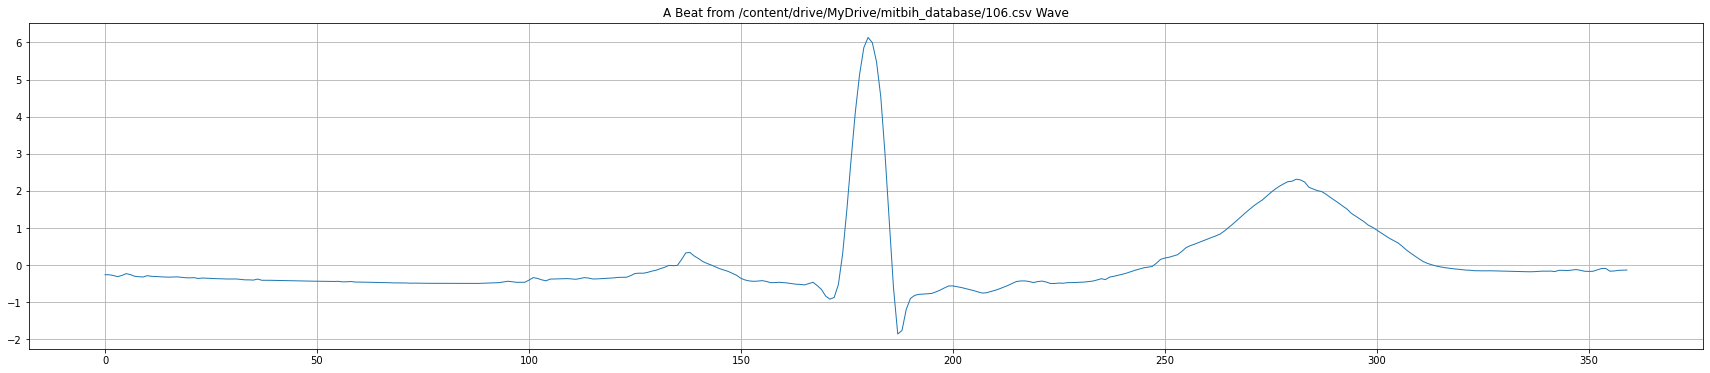

(100012, 360) (100012,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
  
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

            # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


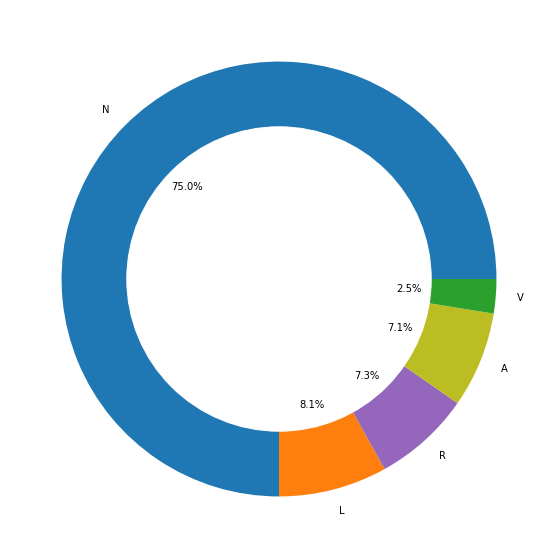

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=6000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=6000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=6000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=6000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=6000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    6000
1.0    6000
2.0    6000
3.0    6000
4.0    6000
Name: 360, dtype: int64


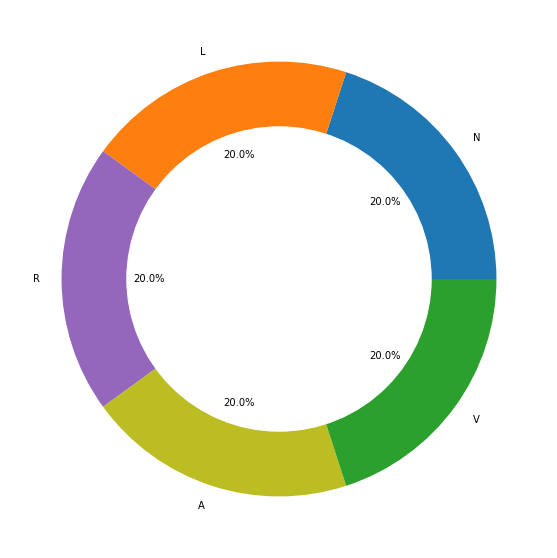

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20,random_state = 42)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (24000, 361)
X_test  :  (6000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(24000, 5) (6000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(24000, 360, 1) (6000, 360, 1)


In [ ]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=9,  padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))
# model.add.layers.GlobalAveragePooling1D(
#     data_format="channels_last", keepdims=False, **kwargs
# )





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=24, kernel_size=11, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=56, kernel_size=13, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=96, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))

# droput layer added before 5th conv layer
model.add(Dropout(0.5))

model.add(Conv1D(5, kernel_size=9, padding='same', activation='relu'))    # here 5 is no of classes, i.e classes in output

# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
# model.add(Flatten())


# # Dropout the layer S9
# model.add(Dropout(0.5))



# #Adding a Dense layer with regularization l2(0.0001)# S10
# # No. of inputs = 2688
# # No. of outputs = 35
# # No. of parameters = 2688 x 35 + 35 = 94115
# model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
# model.add(Dense(35,input_dim=360, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# # Adding a Dense layer with regularization l2(0.0001)# S11
# # No. of inputs = 35
# # No. of outputs = 5
# # No. of parameters = 35*5 + 5 = 180
# model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))


# adding globalavgpooling layer
model.add(GlobalAveragePooling1D())
# model.add(Flatten())
# model.add(Flatten())
# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           160       
                                                                 
 average_pooling1d (AverageP  (None, 179, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 24)           4248      
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 24)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 56)            17528     
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 56)           0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, batch_size=36, epochs=20, verbose=1, validation_data=(test_x, test_y))

Epoch 1/20
667/667 [==============================] - 35s 52ms/step - loss: 0.5598 - accuracy: 0.7930 - val_loss: 0.2214 - val_accuracy: 0.9270
Epoch 2/20
667/667 [==============================] - 34s 51ms/step - loss: 0.2203 - accuracy: 0.9283 - val_loss: 0.1491 - val_accuracy: 0.9515
Epoch 3/20
667/667 [==============================] - 34s 51ms/step - loss: 0.1637 - accuracy: 0.9459 - val_loss: 0.1153 - val_accuracy: 0.9605
Epoch 4/20
667/667 [==============================] - 34s 51ms/step - loss: 0.1359 - accuracy: 0.9528 - val_loss: 0.0912 - val_accuracy: 0.9698
Epoch 5/20
667/667 [==============================] - 36s 54ms/step - loss: 0.1153 - accuracy: 0.9608 - val_loss: 0.0839 - val_accuracy: 0.9743
Epoch 6/20
667/667 [==============================] - 33s 50ms/step - loss: 0.1004 - accuracy: 0.9654 - val_loss: 0.0810 - val_accuracy: 0.9732
Epoch 7/20
667/667 [==============================] - 34s 50ms/step - loss: 0.0868 - accuracy: 0.9712 - val_loss: 0.0755 - val_accuracy:

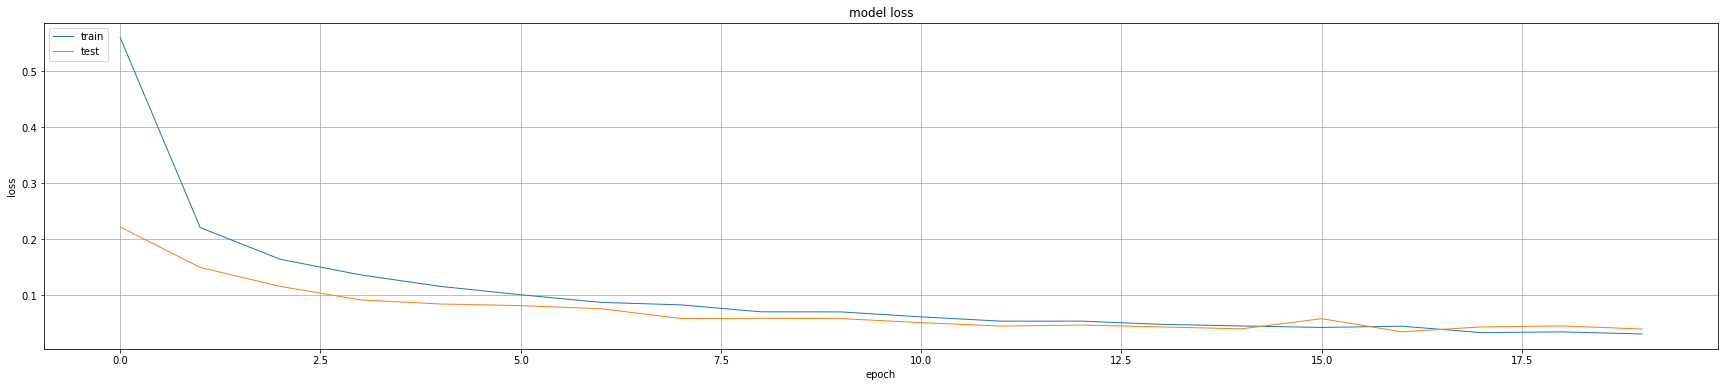

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

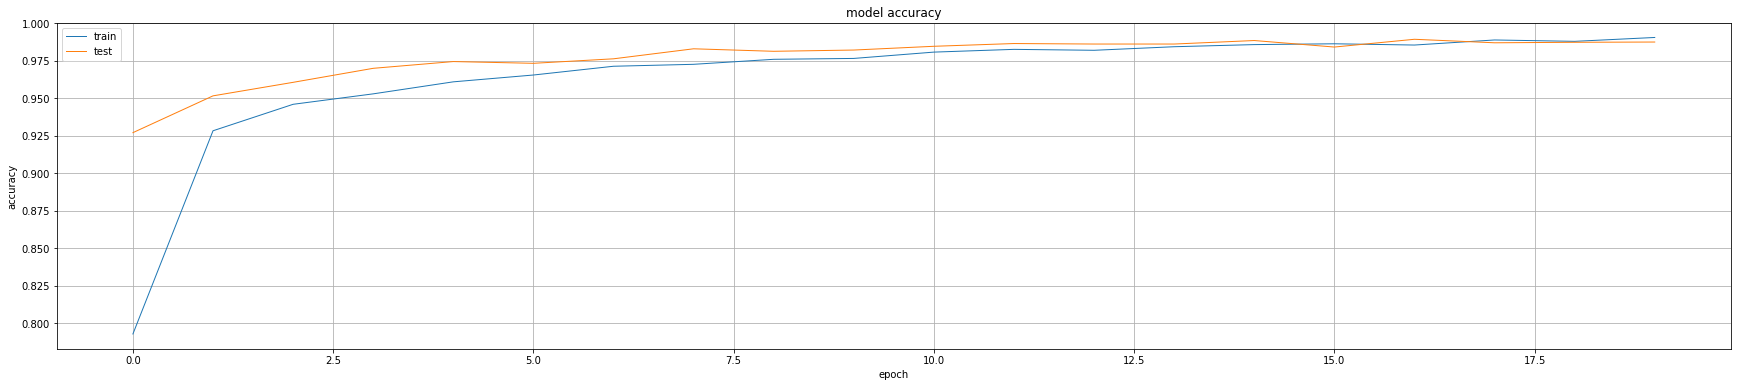

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

188/188 [==============================] - 2s 13ms/step - loss: 0.0392 - accuracy: 0.9873
Test Loss: 0.03918925300240517
Test accuracy: 0.987333357334137


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix

188/188 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           N       0.98      0.97      0.97      1179
           L       1.00      1.00      1.00      1244
           R       1.00      1.00      1.00      1216
           A       0.98      0.97      0.98      1171
           V       0.98      1.00      0.99      1190

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



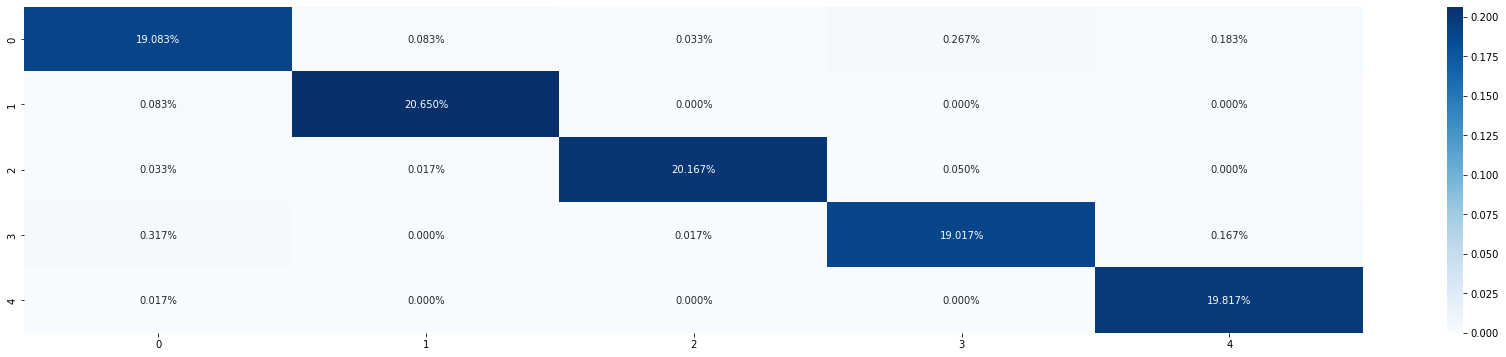

In [ ]:
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
print(classification_report(y_true, prediction, target_names=classes))
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [ ]:
print('Precision: %.3f' % precision_score(y_true, prediction, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true, prediction, average='micro'))
print('Recall: %.3f' % recall_score(y_true, prediction, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true, prediction))

Precision: 0.987
F1 Score: 0.987
Recall: 0.987
Accuracy: 0.987


In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
plotCorrelationMatrix()

adas
